# Prototype notebook to reconstruct all PETRIC data

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR #the main reconstructor
import scipy.ndimage as ndi # used to do some processing on the images
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
# path of the folder containing all the needed input data
betaPen = 0.0008
data_path = '/mnt/share/petric/Siemens_mMR_NEMA_IQ'

In [3]:
STIR.set_verbosity(1)

## Manual RDP

The gradient is not needed unless the image is allowed to contain negative numbers

At the moment I cannot find a way to computed the step size directly in STIR (could be quite useful)

### Gradient calculation

In [4]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) \
                /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


### RDP hess Diag

In [5]:
def rdp_hess_diag (inpImm_,kappa_,eps_,beta_,pixS_):
    inpImm_ = ndi.gaussian_filter(inpImm_,1.3)
    rdpG_ = np.zeros_like(inpImm_)
      
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
          #          print('continuing')
                    continue
                eDist = pixS_[1]/ np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]     
                rdpG_ += (eDist*2)*(kappa_*sk_)*(eps_ +2 * shiftImm_)**2 /(inpImm_+ shiftImm_ + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 3 
                
    rdpG_ *= beta_
    rdpG_ = ndi.gaussian_filter(rdpG_,0.6)
    return rdpG_

### Value calculation (not often needed)

In [6]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    valNP = np.zeros(inpImm_.shape)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
               #     print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]  
                    sk_[-1,:,:] = kappa_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    sk_[0,:,:] = kappa_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                #valNP += 0.5* (inpImm_-shiftImm_)**2 * wI
        
                val += np.sum(np.sum(np.sum(0.5* (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
    return val

### RDP step size denominator


In [7]:
def rdp_den_exact (inpImm_,sDir_,kappa_,eps_,pixS_,beta_=1/700,alpha_=0):
          
    ssDen = 0
    

    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0):                
                    continue
                eDist = pixS_[1]/ np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))                         
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                

                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + 2 * np.abs(inpImm_-shiftImm_) + eps_)**3
                wI *= (kappa_*sk_ )
                wI *= ((2*shiftImm_+eps_)**2 *  sDir_**2 -(2*inpImm_+eps_)*(2*shiftImm_+eps_)*sDir_*shiftSI_)
                
                ssDen += np.sum(np.sum(np.sum(wI,axis=-1),axis=-1),axis=-1)
    ssDen *= (2*beta_)
    return ssDen        

# STIR Setup

Load the image, smooth it lightly, and zero it when its value is low (hopefully it speeds up convergence?)

Also loads the reference image to plot convergence later

In [8]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))
inpImage = image.as_array()
#inpImage = ndi.gaussian_filter(inpImage,0.75)
penEps = inpImage.max()*1e-3

refImm = STIR.ImageData('/workdir/refs/nema_mMR/reference_image.hv')
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

## Set up the relative difference prior computed by STIR

In [9]:
stir_prior = STIR.CudaRelativeDifferencePrior()
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(betaPen) #1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

## Set up the acquisition model

1. Read the sinogram, the starting image and the corrections. Set them upn in an acquisitionModel
2. To compute the step size, define a model without additive corrections. If one declares an independent one, it duplicate memory use. By using get_linear_acquisition_model() RAM is not wasted


In [10]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
addCorr2 = addCorr.clone()
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
ss_model = acq_model.get_linear_acquisition_model()

In [11]:
addCorr2 *= multCorr
addCorr2 += rMax

# My Kappa

Do GE-like BP(multCorr) rescaled for z-profile

put the results in newKarr  as numpy array and in kappa as STIR object

In [12]:
# tImmArrSm = ndi.gaussian_filter(inpImage,0.8)
# image.fill(tImmArrSm)
# ybar = acq_model.forward(image)


In [13]:
kappa = acq_model.backward(template.get_uniform_copy(1))
newKappa = kappa
newKarr = newKappa.as_array()
newKprof = np.mean(np.mean(newKarr,axis=2),axis=1)
nz = image.dimensions()[0]
zv = np.arange(-(nz-1)/2,(nz+1)/2)
zv = np.abs(zv)
zv[zv<0.5]=0.5
zv = 0.5 + 0.5*( 1-zv/((nz-1)/2))
zv = zv.reshape((nz,1,1))
newKprof = newKprof.reshape((nz,1,1))
zv = zv/newKprof
newKarr = newKarr*zv
kernel = np.ones((3,))/3
newKarr = ndi.convolve1d(newKarr,kernel,axis=0,mode='constant')
newKarr *=4.4
newKarr *=100
newKarr *=700
newKarr = np.sqrt(newKarr)
kappa.fill(newKarr)

# My Preconditioner

(BP (1/\bar{y} (FP(1)))

Open issue: do we really need FP(1)? It takes an extra forward projection! (\bar{y} at least gets reused)
No, FP1 worsen convergence

1. Save my diagonal preconditioner in SIRF format (to be used when doing diagonal preconditioning)
2. Save its square root in np format (to be used when doing diagonal + filter)

In [14]:
ybar = acq_model.forward(image)
myKStir = acq_model.backward(multCorr/ybar)
myKarr = myKStir.as_array()
myKarr += rdp_hess_diag (image.as_array(),newKarr,penEps,betaPen,image.voxel_sizes())

### Mask and BP dilation
1. take the mask only where BP exists
2. Erode it by 1
3. Dilate the preconditioner to avoid borders (but it's 0 outside anyway?!)
4. Smooth it by gaussian sigma=2 (?)
5. put in **myK** the 1/sqrt(BP(multCorr**2)) numpy array
6. put in the same in **myPrec** as STIR object

In [15]:
mask = myKStir.as_array()>1e-10

In [16]:
structuring_element = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]]).astype(bool)
structuring_element = structuring_element.reshape((1,3,3))  
precDil = myKarr  
inMask = ndi.binary_erosion(mask,structure=structuring_element)
for _ in range(22):
    precDil = ndi.grey_dilation(precDil,structure=structuring_element)
    precDil[inMask] = myKarr[inMask]


precDil += 1e-5
precDil = ndi.gaussian_filter(precDil,2)
myK = np.sqrt(1/precDil)

In [17]:
myPrec = image.get_uniform_copy(0)
myPrec.fill(myK)

### Prior hess Times one (Stir does it but I don't like it)

In [18]:
def priorHessTimesOne (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                #    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += 2*tempW*(eps_+2*shiftImm_)**2 / (inpImm_+shiftImm_+2*np.abs(inpImm_-shiftImm_)+eps_)**3
                
    return rdpG_

### Define the filter

This is a 2D interpolation of the ram-lak filter, convolved with the shepp-logan window.
It also includes the possibility to account for TOF if present.

In [19]:
def makeFFT_2D_filter (imShape_,tRes_=0,pixS_=2):
    d_ = .95
    order = 2*np.power(2,np.ceil(np.log2(imShape_[1]))).astype(np.uint32)
   # freqN = np.power(2,np.ceil(np.log2(imShape_[1]//2))).astype(np.uint32)
    print (order)
    freqN = order//2
    nFreq = np.arange(0,freqN +1)
    filtImpResp = np.zeros((len(nFreq),))
    filtImpResp[0]=1/4
    filtImpResp[1::2]=-1/((np.pi*nFreq[1::2])**2)

    #TOF part
    if (tRes_ > 0):
        xV_ = nFreq*pixS_
        tRes_ = tRes_*0.15/2.35 # 300 mm /ns --> .3 mm/ps --> /2 because 2 photons 
        tKern_ = np.exp(-(xV_**2/(4*tRes_**2)))
        filtImpResp *=tKern_

    # Once the filter has been defined in image space, convert it to Fourier space
    filtImpResp = np.concatenate([filtImpResp,filtImpResp[-2:0:-1]])
    ftFilt = 2 * np.real(np.fft.fft(filtImpResp)) # check! when implemented correctly the imag part is zero within numerical precision
    ftFilt = ftFilt[:(freqN+1)]
    
    # Apply the shepp-logan window
    fV = 2*np.pi*(np.arange(1,freqN+1))/imShape_[1]
    ftFilt[1:] *= (np.sin(fV/(2*d_)) / (fV/(2*d_)))
    ftFilt[ftFilt<0]=0

    # interpolate to 2D
    xf = np.arange(0,imShape_[1]//2+1).reshape((1,imShape_[1]//2+1))
    yf = xf.transpose()
    freqR = np.sqrt(xf**2+yf**2)
    interpF = np.interp(freqR,nFreq,ftFilt,right=0)
    if (imShape_[1]%2):
            interpF = np.concatenate([interpF,interpF[-1:0:-1,:]],axis=0)
            interpF = np.concatenate([interpF,interpF[:,-1:0:-1]],axis=1)
            interpF = interpF.reshape((1,)+imShape_[1:])            
    else:
            interpF = np.concatenate([interpF,interpF[-2:0:-1,:]],axis=0)
            interpF = np.concatenate([interpF,interpF[:,-2:0:-1]],axis=1)
            interpF = interpF.reshape((1,)+imShape_[1:])
 #   interpF = interpF.reshape((1,)+imShape_[1:])
    return interpF
    


In [20]:
myFilt = makeFFT_2D_filter(inpImage.shape) # Add TOF res and pixel size if problem is TOF

512


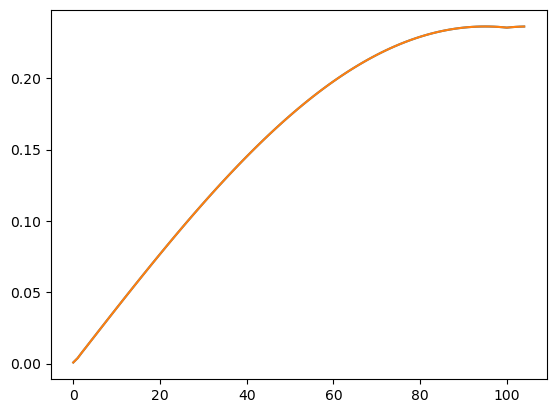

In [21]:
plt.plot(myFilt[0,0,:105])
plt.plot(myFilt[0,:105,0])

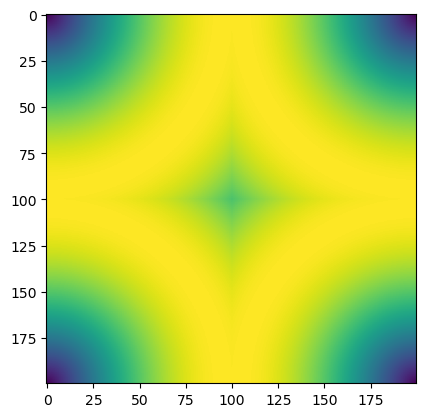

In [22]:
plt.imshow(myFilt[0,:,:])

# Recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [70]:
# # UNCOMMENT and run to "restart" from the clean image
im2 = ndi.gaussian_filter(inpImage,2)

image.fill(im2)
fwdProj = acq_model.forward(image) #,out=fwdProj)

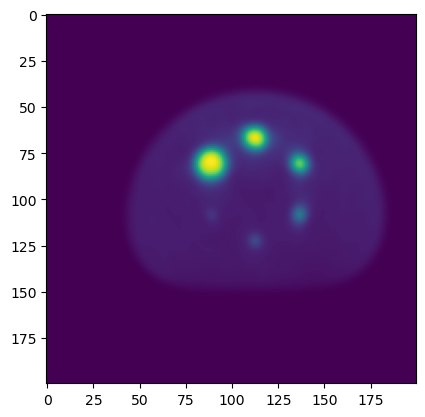

In [69]:
plt.imshow(im2[72,:,:])

In [71]:
nIt = 1
conjugateFlag = False

recItV = np.zeros((nIt+1,) + inpImage.shape)
recItV[0,:,:,:] = image.as_array()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)
grad = image.get_uniform_copy(0)

for itIdx in range(nIt):
    capFact = 2.5/(5+(itIdx/10)**2)
    gradSino = (template-fwdProj)/fwdProj.maximum(addCorr*capFact)
    acq_model.backward(gradSino,out=gradI) #*multCorr)
    pGrad = betaPen*rdp_grad(image.as_array(),newKarr,penEps,image.voxel_sizes()) #stir_prior.gradient(image)
    gradArr = gradI.as_array()
    gradArr -=pGrad
    grad.fill(gradArr)

    gradArr *= (myK)
    gradArr = ndi.gaussian_filter(gradArr,(0.3,0,0))    
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    gradArr *= myK
    # put the results in the STIR array
    sDir.fill(gradArr*mask)

    # Uncomment to conver to conjugate 
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    # # Tomographic step size
    ss_model.forward(sDir,out=fPsDir) 
    ssNum = sDir.dot(grad)
    ssDen = fPsDir.dot((fPsDir/fwdProj.maximum(addCorr*capFact)))
    rdpDen = rdp_den_exact (image.as_array(),sDir.as_array(),newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)
    ss = ssNum/( ssDen+rdpDen)
 #   image += ss*sDir
    print (f'num= {ssNum:.2e} denT= {ssDen:.2e} denRDP= {rdpDen:.2e}')

 #   fwdProj += ss*fPsDir
 #   recItV[itIdx+1,:,:,:] = image.as_array()
    
    

continuing
num= 1.36e+03 denT= 2.95e+00 denRDP= 1.98e+02


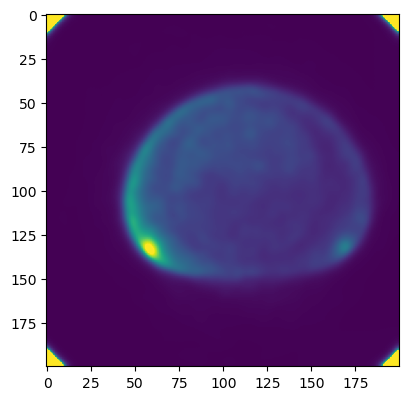

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow((myK**2)[11,:,:],vmax=.0000015) #,vmin=.99,vmax=1.01) #,vmin=0,vmax=.0005)
#plt.colorbar()
# plt.subplot(122)
# plt.imshow(precCode.as_array()[60,:,:],vmin=0,vmax=.0005)

In [72]:
sDirNF = grad.as_array()*(myK**2)

In [73]:
ssOldNum = np.dot(sDirNF.flat,grad.as_array().flat)
i0 = image.get_uniform_copy(0)
i0.fill(sDirNF)
fpSO = ss_model.forward(i0) 
ssDenO = fpSO.dot((fpSO/fwdProj))
denRDPO = rdp_den_exact (image.as_array(),sDirNF,newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)

In [74]:
ssOldNum, ssDen,denRDPO
ssO = ssOldNum/(ssDenO+denRDPO)
print(f'No filter: {ssOldNum:.1e}, {ssDenO:.1e}, {denRDPO:.1e}')
print(f'ss:{ssO:.2e}')

No filter: 3.7e+04, 7.4e+03, 6.8e+03
ss:2.59e+00


In [75]:
print(f'filter: {ssNum:.1e}, {ssDen:.1e}, {rdpDen:.1e}')
print(f'ss:{ss:.2e}')

filter: 1.4e+03, 2.9e+00, 2.0e+02
ss:6.79e+00


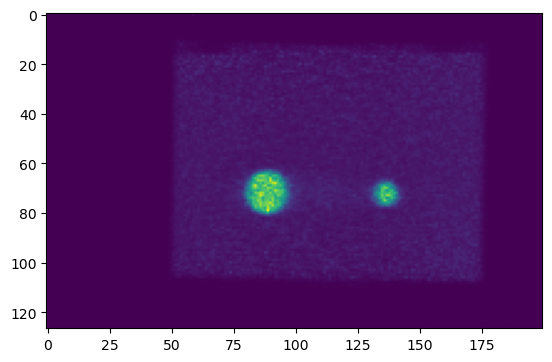

In [76]:
plt.imshow((inpImage)[:,80,:])

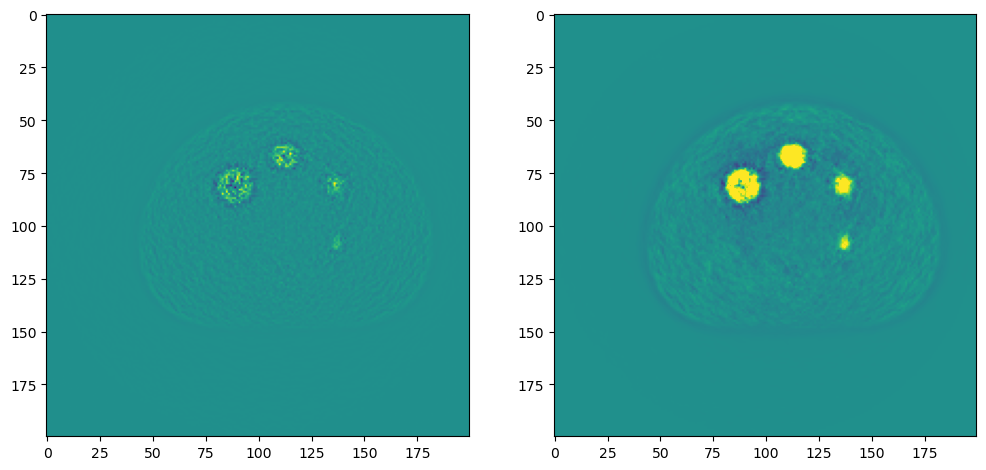

In [77]:
plt.figure(figsize=(12,10))
plt.subplot(121)
#plt.imshow((gradI.as_array()*myK**2)[42,:,:]) #,vmin=-3e-4,vmax=3e-4)
#plt.imshow((pGrad*myK**2)[:,:,120],vmax=.0005,vmin=-.0005) #,vmin=-3e-4,vmax=3e-4)
#plt.imshow((image.as_array()+7.42*sDir.as_array())[60,63:143,65:145]) #,vmin=-2e-3,vmax=2e-3)
plt.imshow((6.86*sDir.as_array())[75,:,:],vmin=-4e-3,vmax=4e-3)
#plt.colorbar()
plt.subplot(122)
#plt.imshow((image.as_array()[:,:,100]),vmax=0.003,cmap='gray')
#plt.contour((pGrad*myK**2)[:,:,100],[-0.0002,0.0002]) #,vmin=-3e-4,vmax=3e-4)
#plt.imshow((image.as_array()+1.58*sDirNF)[60,63:143,65:145])#,vmin=-2e-3,vmax=2e-3) #,vmin=-2e-3,vmax=8e-3)
plt.imshow((1.62*sDirNF)[75,:,:],vmin=-4e-3,vmax=4e-3) #,vmin=-2e-3,vmax=8e-3)
#plt.colorbar()

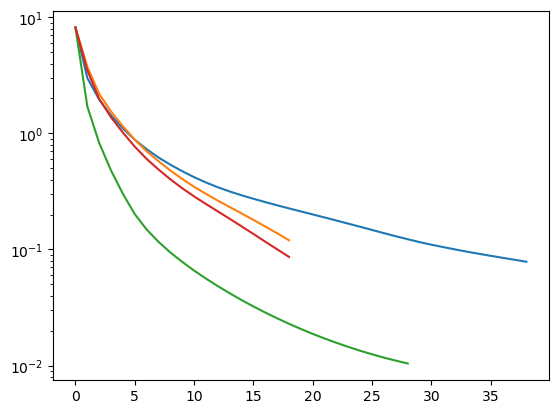

In [532]:
rI = iRef.as_array()#recItV_V2[-1,:,:,:]
dV = (recItV_V3 - np.expand_dims(rI,axis=0))**2
dV2 = (recItV_V2 - np.expand_dims(rI,axis=0))**2
dV3 = (recItV_V1 - np.expand_dims(rI,axis=0))**2
dV4 = (recItV_V4 - np.expand_dims(rI,axis=0))**2
plt.plot(np.sum(np.sum(np.sum(dV,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV2,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV3,axis=-1),axis=-1),axis=-1)[:-2])
plt.plot(np.sum(np.sum(np.sum(dV4,axis=-1),axis=-1),axis=-1)[:-2])
plt.yscale('log')

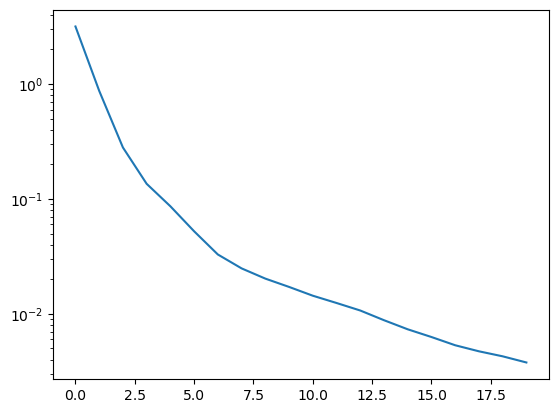

In [508]:
plt.plot(np.sum(np.sum(np.sum(np.diff(recItV_V2,axis=0)**2,axis=-1),axis=-1),axis=-1))
plt.yscale('log')

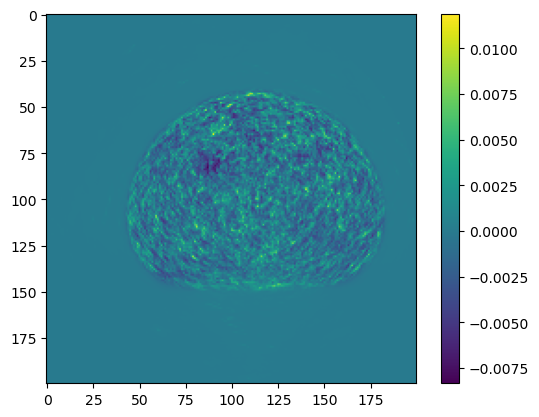

In [62]:
plt.imshow((image.as_array()-iRef.as_array())[84,:,:])
plt.colorbar()

In [78]:
iDiff = (image.as_array()-iRef.as_array())

In [92]:
p1 = np.zeros((200,))
p2 = np.zeros((200,))
for sl in range(30,60):
    p1 += np.abs(np.fft.fft2(iDiff[sl,:,:]))[0,:]+np.abs(np.fft.fft2(iDiff[sl,:,:]))[:,0]
    p2 += np.abs(np.fft.fft2(sDirNF[sl,:,:]))[0,:]+np.abs(np.fft.fft2(sDirNF[sl,:,:]))[:,0]

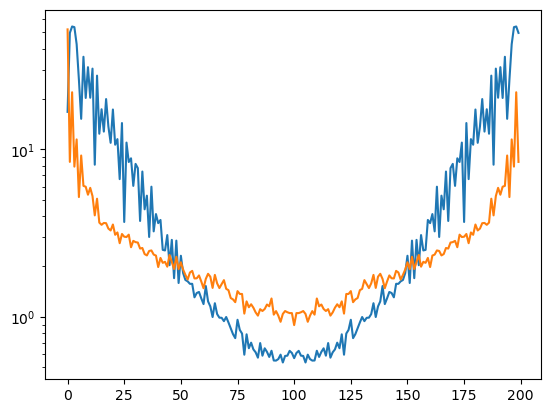

In [93]:
plt.plot(p1)
plt.plot(p2*2)
plt.yscale('log')

/tmp/ipykernel_47452/936630185.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(100)),np.log(p1/p2)[:100])


Text(0.5, 1.0, 'Diff / sDir')

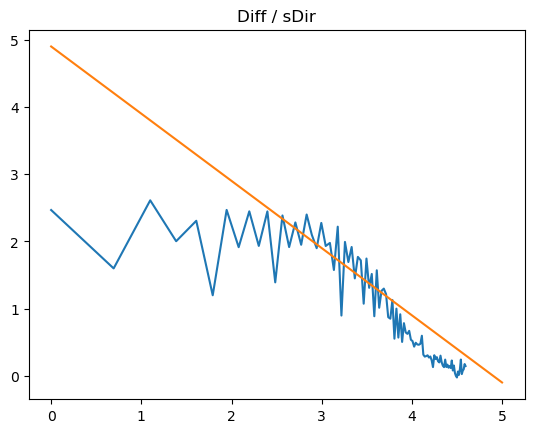

In [94]:
plt.plot(np.log(np.arange(100)),np.log(p1/p2)[:100])
plt.plot(4.9-1*np.arange(6))
plt.title('Diff / sDir')
#plt.yscale('log')
#plt.xc

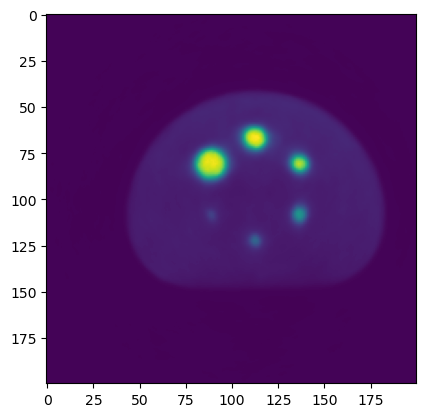

In [86]:
plt.imshow(iRef.as_array()[72,:,:])

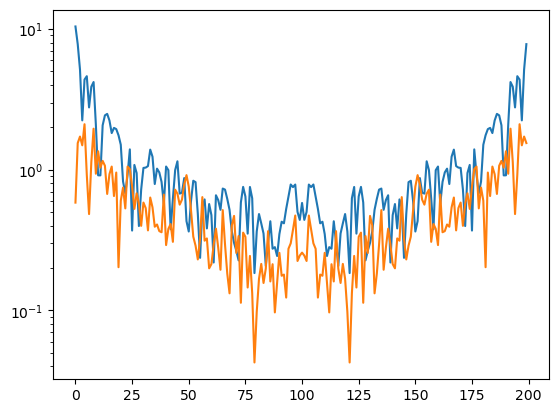

In [82]:
plt.plot(np.abs(np.fft.fft2(iDiff[72,:,:]))[0,:]+np.abs(np.fft.fft2(iDiff[72,:,:]))[:,0])
plt.plot(np.abs(np.fft.fft2(iDiff[54,:,:]))[0,:]+np.abs(np.fft.fft2(iDiff[54,:,:]))[:,0])
#plt.plot(np.abs(np.fft.fft2(iDiff[56,:,:]))[0,:]+np.abs(np.fft.fft2(iDiff[56,:,:]))[:,0])
plt.yscale('log')
#plt.plot(np.abs(np.fft.fft2(iDiff[55,:,:]))[:,0])

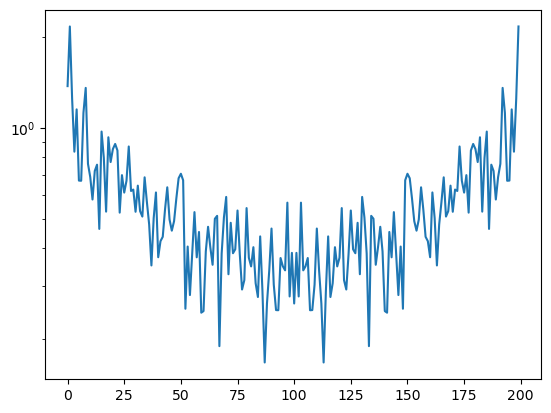

In [78]:
plt.plot(np.abs(np.fft.fft2(sDirNF[55,:,:]))[0,:]+np.abs(np.fft.fft2(sDirNF[55,:,:]))[:,0]+np.abs(np.fft.fft2(sDirNF[54,:,:]))[0,:]+np.abs(np.fft.fft2(sDirNF[54,:,:]))[:,0])

plt.yscale('log')

In [33]:
iRef = STIR.ImageData('./output/geWeight_NegThrSinoCap_DiagLong/mMR_NEMA/iter_0165.hv')


In [170]:
denI = fPsDir*fPsDir/

(11, 127, 200, 200)

In [409]:
i1 = image.as_array()
i1[i1<0].size

1049723

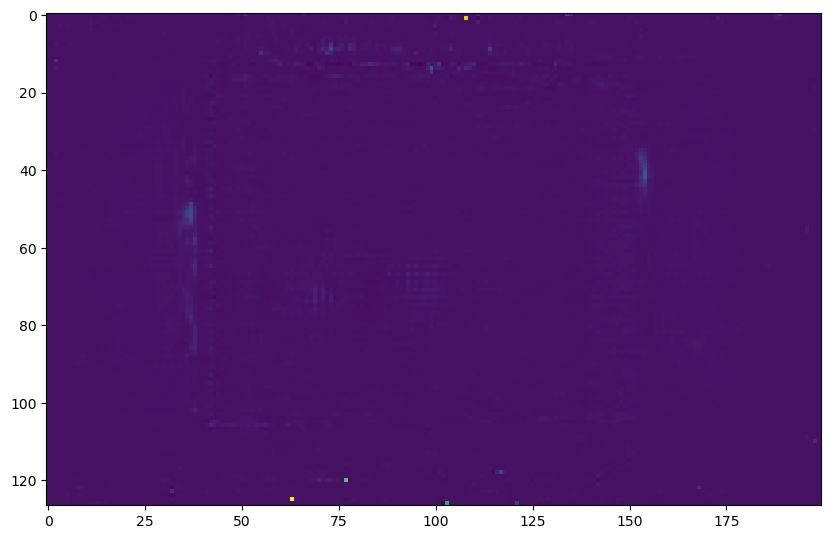

In [514]:
plt.figure(figsize=(10,10))
plt.imshow((sDir.as_array()*grad.as_array())[:,:,100])
#plt.contour(i1[:,:,100],[0],colors='r')

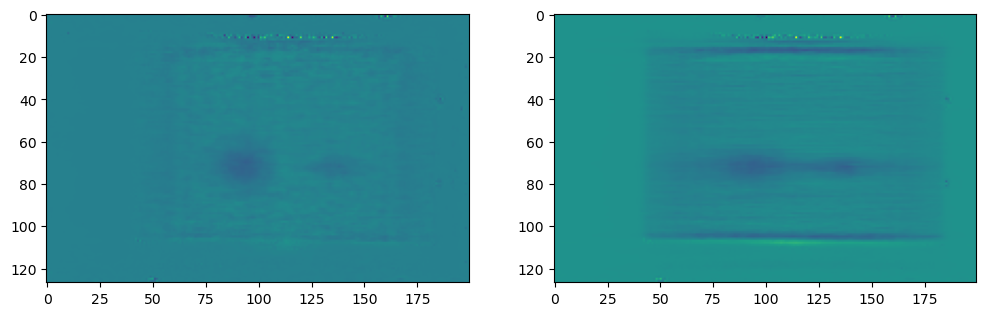

In [407]:
plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(sDir.as_array()[:,100,:])
plt.subplot(122)
plt.imshow((grad.as_array()*myK**2)[:,100,:])

In [400]:
rdpDen,wI = rdp_den_exact (image.as_array(),sDir.as_array(),newKarr,penEps,image.voxel_sizes(),betaPen,alpha_=0)
ssNum/(ssDen+rdpDen)
#inpImm_,sDir_,kappa_,eps_,pixS_,beta_=1/700,alpha_=0)

4.0301550995619415

In [234]:
wI.sum()

51833.664

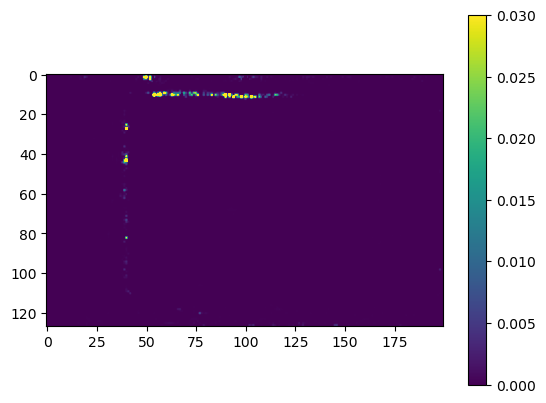

In [405]:
plt.imshow(wI[:,:,100],vmax=.03,vmin=0)
plt.colorbar()

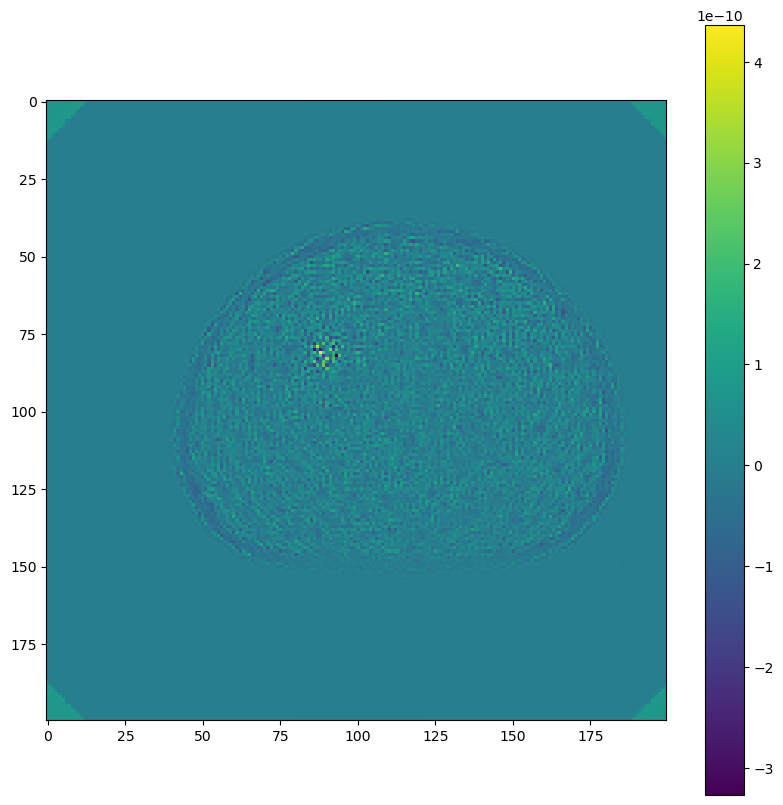

In [130]:
plt.figure(figsize=(10,10))
slIdx=60
#plt.imshow(inpImage[slIdx,:,:])
#plt.imshow(inpImage[slIdx,:,:]+gradArr[slIdx,:,:]*6.7)
plt.imshow(gradArr[slIdx,:,:]*4.3e-7)
plt.colorbar()

In [272]:
image.fill(inpImage)
acq_model.forward(image,out=fwdProj)

In [273]:
nIt = 30
conjugateFlag = True

recItV_V4 = np.zeros((nIt+1,) + inpImage.shape)
recItV_V4[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)

# Non-negative denominator!
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
    gradSino =  (template-fwdProj)/sinDenoStir
    acq_model.backward(gradSino,out=gradI) #*multCorr)

    # Need to use my re-implementation that handles negative denominators.
    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    pGrad.fill(pGradA)
    grad = gradI - pGrad
    
    # Filter part
    gradArr = grad.as_array()
    # apply square root of diagonal prec
    gradArr /= (myKsqroot)
    gradArr *= maskSmooth
    # Convert in fourier and apply the 2D filter in the axial planes
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    # smooth lightly over the z direction
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    # apply diagonal preconditioner
    gradArr /= myKsqroot
    gradArr *= maskSmooth
    # put the results in the STIR array
    sDir.fill(gradArr*mask)
    if conjugateFlag:
        if itIdx>0:
            beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
            sDir += beta * prevSDir 
        prevSDir = sDir.clone()
        gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir,subset_num=0)

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('it: {:d}, num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(itIdx, ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))

    # update image and sinogram
    image += ss*sDir
    fwdProj += ss*fPsDir

    recItV_V4[itIdx+1,:,:,:] = image.as_array()

continuing
it: 0, num: -1.6e+03 den: 1.3e+03 penNum 5.2e+05 penDen 4.2e+06
continuing
it: 1, num: -3.1e+03 den: 1.1e+03 penNum 3.3e+05 penDen 1.1e+06
continuing
it: 2, num: -4.8e+03 den: 3.9e+03 penNum 7.3e+05 penDen 4.4e+06
continuing
it: 3, num: -8.6e+03 den: 4.0e+03 penNum 6.8e+05 penDen 3.6e+06
continuing
it: 4, num: -1.0e+04 den: 5.5e+03 penNum 6.6e+05 penDen 3.6e+06
continuing
it: 5, num: -1.1e+04 den: 5.7e+03 penNum 5.9e+05 penDen 3.4e+06
continuing
it: 6, num: -1.2e+04 den: 6.2e+03 penNum 5.2e+05 penDen 3.2e+06
continuing
it: 7, num: -1.2e+04 den: 6.0e+03 penNum 4.5e+05 penDen 2.8e+06
continuing
it: 8, num: -1.3e+04 den: 6.5e+03 penNum 4.2e+05 penDen 2.7e+06
continuing
it: 9, num: -1.3e+04 den: 6.6e+03 penNum 3.9e+05 penDen 2.5e+06
continuing
it: 10, num: -1.4e+04 den: 6.9e+03 penNum 3.7e+05 penDen 2.3e+06
continuing
it: 11, num: -1.4e+04 den: 7.2e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 12, num: -1.5e+04 den: 7.7e+03 penNum 3.5e+05 penDen 2.2e+06
continuing
it: 13, num